# Part I: Supervised Learining 

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request

In [2]:
#Extract data as an array from the url
# link = "http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/zipcombo.dat"
filename = 'zipcombo.dat'
training_filename = 'dtrain123.dat'
test_filename = 'dtest123.dat'
# urllib.request.urlretrieve(link, filename)
data = np.loadtxt(filename)     # read numpy array from file
# data = np.loadtxt(training_filename)     # read numpy array from file

## Multiclass Perceptron with Polynomial Kernel

In [3]:
y = data[:,0]
x = data[:,1:]

In [4]:
#Not sure if I should include bias before computing the Kernel? 
def add_bias(x):
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias

#Discuss the use of the this kernel. i.e. talk about non-linear seperability. 
def Polynomial_Kernel(x1,x2,d):
    K = (x1 @ x2.T)**d
    return K

def transform_y(y):
    #classes_num = len(y.unique())
    #assuming that training set has all the numbers between min(y) and max(y)
    classes_num = 10
    m = len(y)
    y_matrix = np.ones((m,classes_num))*(-1)
    for i in range(m):
        y_matrix[i,int(y[i])] = 1
    return y_matrix

def pairwise_distance_single(X): # distances of X training data, single X matrix
    m =X.shape[0]
    n = X.shape[1]
    G = np.matmul(X,X.T)
    DG = np.diag(G).reshape(G.shape[0],1)
    distances_sq = np.matmul(DG,np.ones((G.shape[0],1)).T)+ np.matmul(np.ones((G.shape[1],1)),DG.T)-2.0*G
    return distances_sq

def pairwise_distance_double(X1,X2): # distances of X training data, double matrices, X1 and X2
    X1_pow = (X1**2).sum(axis=1).reshape(X1.shape[0],1) #sum the rows, size m1 array
    X2_pow = (X2**2).sum(axis=1).reshape(X2.shape[0],1) #sum the rows, size m2 array
    G = np.matmul(X1,X2.T)
    m1,m2 =G.shape[0],G.shape[1] 
    distances_sq = np.matmul(X1_pow,np.ones((m2,1)).T)+ np.matmul(np.ones((m1,1)),X2_pow.T)-2.0*G
    return distances_sq

def Gaussian_Kernel(distances_sq,c=1):
    K = np.exp(-c*distances_sq)
    return K

In [5]:
def calculate_kernel_single(x, d, kernel_choice):
    if kernel_choice=='Polynomial':
        K_train = Polynomial_Kernel(x,x,d)
#         print("Constructed a Polynomial kernel for training")
    elif kernel_choice=='Gaussian':
        pairwise_distances = pairwise_distance_single(x)
        K_train = Gaussian_Kernel(pairwise_distances,c=d)
#         print("Constructed a Gaussian kernel for training")
    else:
        raise Exception("Unsupported value for kernel. Supported values: Polynomial, Gaussian")
    return K_train

def calculate_kernel_double(x1, x2, d, kernel_choice):
    if kernel_choice=='Polynomial':
        K_train = Polynomial_Kernel(x1,x2,d)
#         print("Constructed a Polynomial kernel for testing")
    elif kernel_choice=='Gaussian':
        pairwise_distances = pairwise_distance_double(x1, x2)
        K_train = Gaussian_Kernel(pairwise_distances,c=d)
#         print("Constructed a Gaussian kernel for testing")
    else:
        raise Exception("Unsupported value for kernel. Supported values: Polynomial, Gaussian")
    return K_train

def perceptron_epoch(x, y, y_arr, alpha, K_train):
    m = x.shape[0] #number of examples
    errors = np.zeros(m)
    num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation

    for t in range(m):
        #find our training set
        x_t = x[t,:] #of size (1,n)
        y_t = y[t]
        y_arr_t = y_arr[t,:] #of size (1,10) 

        #pred_t computes \sum^{t-1}_{i=0} {(alpha_i K(x_t, x_i))}, which is regarded as the confidence in each class
        pred_t = (alpha[:,:].T @K_train[t,:]).T
        y_hat_t = np.where(pred_t==max(pred_t),1,0) #map the confidence to arrays of 1 and 0 for class

        if pred_t.argmax()!=y_t:
            #update the alpha, and weights, for all the classes that not the true class
            num_errors +=1

            #since we only want to update the weights related to first t-1 training data.
            #note that alpha_t is np.zeros(10,1), 
            #and alpha_t is updated according to the real class, and the misclassified class.
            #this version is not updated with alpha_prev

            alpha_t = alpha[t,:] + np.where(y_arr_t> 0,1,0) + np.where(y_hat_t>0,-1,0) #(1,10)

            #store alpha_t into the matrix for future reference
            alpha[t,:] = alpha_t

            #sandwich K(x_t, x_i) for i in [1,t-1] in a zeros array of size(m). 
            #reason being weight for one class is of size(m), but we only 'have enough data' to update the first t-1 terms.  
            K_update = np.zeros((1,m))
            K_update[:,:t] = K_train[t,:t] 

        errors[t] = num_errors
    return alpha, errors

#One vs. rest: train k classifiers to identify k classes
def perceptron_train(x,y,d=2,kernel_choice='Polynomial', convergence_threshold=0.01):
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    classes_num = 10 #number of classes 
     
    error_per_epoch = []
    y_arr = transform_y(y) 
    alpha = np.zeros((m,classes_num)) #Need to store alpha array at all iteration, as we need it to compute confidence
    
    K_train = calculate_kernel_single(x, d, kernel_choice)    
    epochs = 0
    while True:
        alpha, errors = perceptron_epoch(x, y, y_arr, alpha, K_train)
        
        error_rate_current = error_per_epoch[-1] / x.shape[0] if epochs > 0 else 0
        error_rate_next = errors[-1] / x.shape[0]

        error_per_epoch.append(errors[-1])
        if epochs > 0 and (error_rate_next > error_rate_current or \
            error_rate_current - error_rate_next < convergence_threshold):
#             print("Stopping after ", epochs+1," epochs: error_next: ", error_rate_next,", current: ", error_rate_current)
            break
            
        epochs += 1

    return alpha, error_per_epoch

In [6]:
#Test this function, see if it is working properly
alpha, error_per_epoch = perceptron_train(x,y,d=2)

In [7]:
#Plot number of misclassfication versus the number of training sets reviewed. 
ratio = np.asarray(error_per_epoch)/x.shape[0]
err = error_per_epoch[-1]/x.shape[0]
print("err is ", err)
error_per_epoch

err is  0.021294902129490215


[863.0, 378.0, 236.0, 198.0]

Text(0.5, 1.0, 'Proportion of misclassified data points out of data points reviewed')

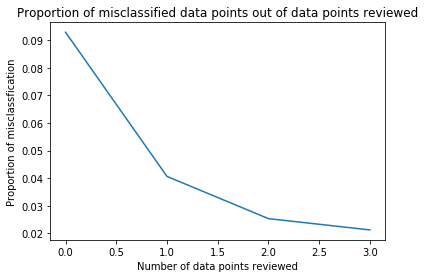

In [8]:
plt.plot(ratio)
plt.ylabel('Proportion of misclassfication')
plt.xlabel('Number of data points reviewed')
plt.title('Proportion of misclassified data points out of data points reviewed')

# Q1 - Basic Results

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd

def allocate_training_test_sets(data,r =1/5):
    X= data[:,1:]
    y= data[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)
    return X_train, X_test, y_train, y_test

In [10]:
def perceptron_test(x_test,x_train,y_test, alphas, d, kernel_choice='Polynomial'):
    K_test = calculate_kernel_double(x_train, x_test, d, kernel_choice)
    
    confidence = (alphas.T @ K_test).T
    preds = np.zeros(confidence.shape)
    mistakes = 0
    for i in range(len(y_test)):
        y_hat = confidence[i].argmax()
        preds[i,y_hat] = 1
        if y_hat != y_test[i]:
            mistakes += 1
    return mistakes, preds, confidence

In [11]:
# CLEANUP in the end, This is just for testing, CLEANUP
X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
alphas, train_errors = perceptron_train(X_train,y_train, 3)
mistakes,_,_ = perceptron_test(X_test, X_train, y_test, alphas, 3)
    
print("Number of mistakes: ", mistakes, ", sample size: ", len(y_test))
print("Ratio mistakes/size: ", mistakes/len(y_test))

Number of mistakes:  68 , sample size:  1860
Ratio mistakes/size:  0.03655913978494624


In [12]:
def basic_results(d_arr, kernel_choice, runs):
    training_set_errors = np.zeros((len(d_arr),runs))
    test_set_errors = np.zeros((len(d_arr),runs))
    for d in d_arr:
        for i in range(runs):
            print("Now doing run ", i+1, "/", runs, " for d=", d,".........", end='\r')
            X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)
            alphas,_ = perceptron_train(X_train,y_train, d, kernel_choice=kernel_choice)

            train_errors,_,_ = perceptron_test(X_train, X_train, y_train, alphas,d, kernel_choice=kernel_choice)
            test_errors,_,_ = perceptron_test(X_test,X_train, y_test,alphas,d, kernel_choice=kernel_choice)

            training_set_errors[d-1, i] = train_errors / len(y_train)
            test_set_errors[d-1, i] = test_errors / len(y_test)
    return training_set_errors, test_set_errors
            
d_arr = np.arange(1,8)
runs = 2
training_set_errors, test_set_errors = basic_results(d_arr, 'Polynomial', 2)

In [13]:
def construct_dataframe_error_rates(training_set_errors, test_set_errors):
    means_std = []
    for d in d_arr:
        data_t = []
        data_t.append("{0:.4f} +- {1:.4f}".format(training_set_errors[d-1].mean(), \
                                                np.std(training_set_errors[d-1])))
        data_t.append("{0:.4f} +- {1:.4f}".format(test_set_errors[d-1].mean(), \
                                                np.std(test_set_errors[d-1])))
        means_std.append(data_t)
    return means_std
    
means_std = construct_dataframe_error_rates(training_set_errors, test_set_errors)
df = pd.DataFrame(data=means_std, index=d_arr, columns=['Training set error rate', 'Test set error rate'])
df

,Training set error rate,Test set error rate
1,0.0800 +- 0.0091,0.1048 +- 0.0065
2,0.0218 +- 0.0015,0.0538 +- 0.0022
3,0.0092 +- 0.0026,0.0387 +- 0.0011
4,0.0026 +- 0.0003,0.0309 +- 0.0008
5,0.0029 +- 0.0006,0.0328 +- 0.0032
6,0.0022 +- 0.0007,0.0309 +- 0.0035
7,0.0019 +- 0.0003,0.0341 +- 0.0019


# Q2 - Cross Validation

Having already allocated x_train, now perform cross validation on x_train

In [14]:
def cross_validation(X, y, kernel_choice, d, k):
    kf = KFold(n_splits=k, shuffle=True)
    MSE_cv_arr = np.zeros(k)
    i = 0
    for train_index, cv_index in kf.split(X):
        # Spit the matrix using the indices gained by the CV method and construct X and Y arrays
        X_train = X[train_index]
        X_cv = X[cv_index]
        y_train = y[train_index]
        y_cv = y[cv_index]
    
        # We are only interested in the alphas and not the MSE on the training set
        alphas, errors = perceptron_train(X_train, y_train, d, kernel_choice = kernel_choice)
        mistakes,_,_ = perceptron_test(X_cv, X_train, y_cv, alphas, d, kernel_choice = kernel_choice)
        MSE_cv_arr[i] = mistakes / len(y_cv)
        i += 1
        
    return MSE_cv_arr.mean(), np.std(MSE_cv_arr)

In [15]:
def cv_process(d_arr, runs, kernel_choice, calculate_confusions):
    d_stars = np.zeros(runs)
    test_errors = np.zeros(runs)
    confusions = []
    mistakes_per_run = np.zeros(x.shape[0])

    for j in range(runs):
        confusion = np.zeros((10, 10))

        print("WARNING: Change the number of runs to 20!!!")
        # In each run we will iterate through the d array and use all possible values of d

        # Allocate 80/20 percent for training and test set
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)

        CV_means = np.zeros(len(d_arr))
        for i in range(len(d_arr)):
            print("Now doing run ", j+1, "/", runs, " for d=", d_arr[i], ".........", end='\r')
            MSE_CV_mean, _ = cross_validation(X_train, y_train, kernel_choice, d_arr[i], k=5)
            CV_means[i] = MSE_CV_mean

        # Train in whole 80% now with d_star
        d_stars[j] = CV_means.argmin()
        alphas, errors = perceptron_train(X_train, y_train, d_stars[j], kernel_choice = kernel_choice)

        mistakes,_,_ = perceptron_test(X_test, X_train, y_test, alphas, d_stars[j], kernel_choice = kernel_choice)
        test_errors[j] = mistakes / len(y_test)
        
        if calculate_confusions:
            # Test in all the data set, so that we know which ones
            # are the "toughest" to predict in the whole data set. We can't really just do it on 
            # either the training or test set, as it is randomly split so order will not be pertained.
            _, preds_all, confidences = perceptron_test(x, X_train, y, alphas, d_stars[j], kernel_choice = kernel_choice)
            for i in range(x.shape[0]):
                pred_label = preds_all[i].argmax()
                if pred_label != y[i]:
                    confusion[int(y[i]), pred_label] += 1
                    mistakes_per_run[i] += 1

            confusions.append(confusion)
    return d_stars, test_errors, confusions, mistakes_per_run
    
runs = 2
d_stars, test_errors, confusions, mistakes_per_run = cv_process(d_arr, runs, 'Polynomial', True)

In [16]:
print("Mean d*: ", d_stars.mean(), " with std: ", np.std(d_stars))
print("Mean test error: ", test_errors.mean(), " with std: ", np.std(test_errors))

Mean d*:  5.0  with std:  0.0
Mean test error:  0.03521505376344086  with std:  0.0029569892473118274


# Q3 - Confusion Matrix

In [17]:
#Might need to use pandas for it
confusions_matrix = []
for i in range(10):
    confusions_i = []
    for j in range(10):
        confusions_ij = np.asarray([confusions[r][i,j] for r in range(runs)])
        confusions_i.append("{0:.2f} +- {1:.2f}".format(confusions_ij.mean(), np.std(confusions_ij)))
    confusions_matrix.append(confusions_i)
    
df = pd.DataFrame(data=confusions_matrix)
df

,0,1,2,3,4,5,6,7,8,9
0,0.00 +- 0.00,0.00 +- 0.00,0.50 +- 0.50,1.00 +- 0.00,1.50 +- 0.50,0.50 +- 0.50,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.00
1,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.00,1.00 +- 1.00,1.50 +- 0.50,0.50 +- 0.50,0.00 +- 0.00,0.50 +- 0.50,1.50 +- 1.50,1.50 +- 1.50
2,2.50 +- 1.50,0.50 +- 0.50,0.00 +- 0.00,1.50 +- 0.50,1.00 +- 0.00,0.50 +- 0.50,0.00 +- 0.00,1.50 +- 0.50,1.00 +- 0.00,1.00 +- 1.00
3,1.00 +- 1.00,0.00 +- 0.00,1.00 +- 1.00,0.00 +- 0.00,0.00 +- 0.00,2.00 +- 1.00,0.00 +- 0.00,1.00 +- 0.00,6.00 +- 4.00,2.00 +- 2.00
4,0.00 +- 0.00,3.50 +- 0.50,0.50 +- 0.50,0.50 +- 0.50,0.00 +- 0.00,0.00 +- 0.00,1.00 +- 0.00,0.50 +- 0.50,0.50 +- 0.50,1.50 +- 0.50
5,2.00 +- 2.00,0.00 +- 0.00,0.00 +- 0.00,2.50 +- 0.50,1.00 +- 1.00,0.00 +- 0.00,6.50 +- 1.50,0.00 +- 0.00,2.50 +- 1.50,2.50 +- 2.50
6,3.00 +- 1.00,1.00 +- 1.00,0.50 +- 0.50,0.00 +- 0.00,1.50 +- 0.50,1.00 +- 1.00,0.00 +- 0.00,0.00 +- 0.00,0.50 +- 0.50,0.00 +- 0.00
7,0.00 +- 0.00,0.00 +- 0.00,1.00 +- 1.00,0.00 +- 0.00,4.00 +- 3.00,0.50 +- 0.50,0.00 +- 0.00,0.00 +- 0.00,0.50 +- 0.50,10.50 +- 6.50
8,0.00 +- 0.00,0.50 +- 0.50,0.50 +- 0.50,2.00 +- 2.00,0.50 +- 0.50,2.00 +- 2.00,0.00 +- 0.00,0.50 +- 0.50,0.00 +- 0.00,0.50 +- 0.50
9,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.00,0.50 +- 0.50,2.50 +- 0.50,0.00 +- 0.00,0.00 +- 0.00,2.00 +- 0.00,0.50 +- 0.50,0.00 +- 0.00


# Q4 - Hardest numbers to predict

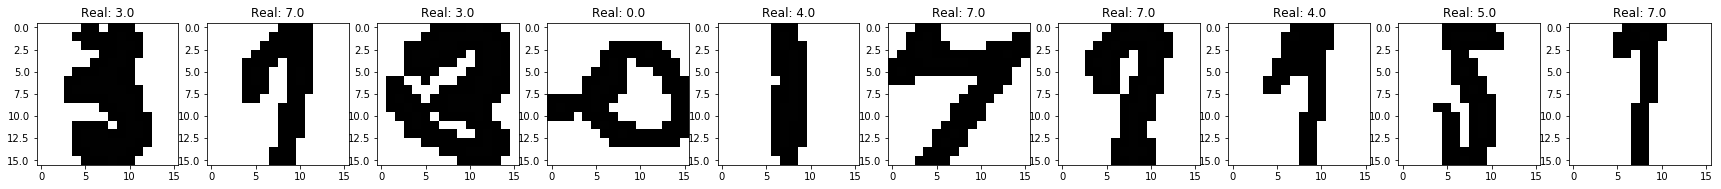

In [18]:
# We only have to show 5, but let's show 10 for the purposes of seeingthat indeed the first 5 are the worst
indices = np.flip(np.argsort(mistakes_per_run))[:10]

plt.figure(figsize=(30,30))

k = 1
for i in indices:
    a1 = plt.subplot(1, 10, k)
    pixels = np.array(x[i], dtype='uint8')
    pixels = pixels.reshape((16, 16))
    plt.title("Real: {0}".format(y[i]))
    a1.imshow(pixels, cmap='gray')
    k+=1

# Q5 - Gaussian Kernel

In [20]:
runs = 2
d_arr = np.arange(1,8)

training_set_errors, test_set_errors = basic_results(d_arr, 'Gaussian', runs)
means_std = construct_dataframe_error_rates(training_set_errors, test_set_errors)
df = pd.DataFrame(data=means_std, index=d_arr, columns=['Training set error rate', 'Test set error rate'])
df

,Training set error rate,Test set error rate
1,0.0000 +- 0.0000,0.0565 +- 0.0081
2,0.0001 +- 0.0001,0.0616 +- 0.0024
3,0.0000 +- 0.0000,0.0629 +- 0.0043
4,0.0000 +- 0.0000,0.0621 +- 0.0024
5,0.0001 +- 0.0001,0.0704 +- 0.0059
6,0.0000 +- 0.0000,0.0804 +- 0.0013
7,0.0000 +- 0.0000,0.0968 +- 0.0075


In [21]:
#Cross Validation with Gaussian Kernel, find c_star
runs = 2
d_stars, test_errors, confusions, mistakes_per_run = cv_process(d_arr, runs, 'Gaussian', False)
print("Mean d*: ", d_stars.mean(), " with std: ", np.std(d_stars))
print("Mean test error: ", test_errors.mean(), " with std: ", np.std(test_errors))

Mean d*:  1.0  with std:  1.07 .........
Mean test error:  0.48655913978494625  with std:  0.4295698924731183


# Q6 - Choose an alternative method to generalise k-classes

# Q7 - Choose two more algorithms to compare

### Multinomial Logistic Regression 

In [238]:
#One against rest approach
#Problem: What is the hyperparameter to be tuned? C-value: C = 1/lambda, which is the regularization coefficient. 
#https://stackoverflow.com/questions/21816346/fine-tuning-parameters-in-logistic-regression
#http://dataaspirant.com/2017/05/15/implement-multinomial-logistic-regression-python/
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
# Train multi-classification model with logistic regression
lr = LogisticRegression(C=1,random_state=0, solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)

In [245]:
from sklearn import metrics
#print ("Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, lr.predict(x_train)))
#print ("Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, lr.predict(x_test)))
print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, lr.predict(X_test)))
 

Multinomial Logistic regression Train Accuracy ::  0.9904544232320516
Multinomial Logistic regression Test Accuracy ::  0.9354838709677419


In [ ]:
# Different ideas - LR uses probability theory, it'd be interest to compare with perceptron which is simply geometric. 

### Support Vector

In [ ]:
#One against one approach, or One against All approach? 

In [ ]:
#Maybe logistic regression and SVM. 
